In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/patator.csv')

In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [7]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [11]:
selected_features_indices = selector.get_support(indices=True)

In [12]:
selected_feature_names = X.columns[selected_features_indices]

In [13]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Fwd PSH Flags', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Average Packet Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'act_data_pkt_fwd'],
      dtype='object')


In [14]:
# Load the saved models
rf_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/rf_model_patator.pkl')
svm_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/patator_svm.pkl')
lg_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/patator_logistic.pkl')

In [15]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('svm', svm_model),
    ('logistic regression', lg_model)
], voting='hard')

In [16]:
# Fit the ensemble model on the training data
voting_clf.fit(X_train_selected, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('logistic regression',
                              LogisticRegression(max_iter=1000))])

In [17]:
# Predictions
y_pred_ensemble = voting_clf.predict(X_test_selected)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Evaluation metrics
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')
ensemble_conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

In [19]:
# Print evaluation metrics
print("Ensemble Model Evaluation:")
print("Accuracy:", ensemble_accuracy)
print("Precision:", ensemble_precision)
print("F1-score:", ensemble_f1)
print("Confusion Matrix:")
print(ensemble_conf_matrix)

Ensemble Model Evaluation:
Accuracy: 0.9897676401620124
Precision: 0.9896997929475011
F1-score: 0.9885889576936057
Confusion Matrix:
[[86055   219    36]
 [    8  1579     0]
 [  645     4   583]]


In [20]:
# Define class names
y_probs = voting_clf.predict_proba(X_test_selected)

class_names = ['benign', 'web attack brute force', 'web attack sql injection', 'web attack xss']
# Compute ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(voting_clf.classes_)):
    fpr, tpr, _ = roc_curve(y_test == voting_clf.classes_[i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=class_names[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AttributeError: predict_proba is not available when voting='hard'

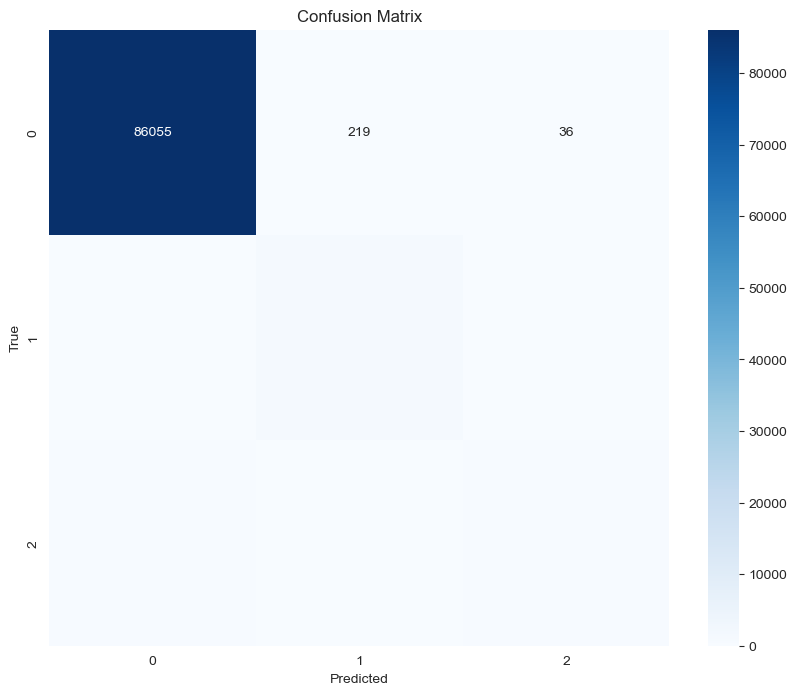

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [22]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 219
False Negatives: 8


In [23]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 89129


In [24]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 0.25%


In [25]:
import joblib

# Save the trained model to a file
joblib.dump(voting_clf, 'patator_ensemble.pkl')

# Load the model from file
# loaded_model = joblib.load('svm_model.pkl')

['patator_ensemble.pkl']